In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Decision Trees - eenvoudig voorbeeld
We willen een model maken dat voorspelt of een student zijn toets voor cm gaat halen. We hebben data over 7 studenten van afgelopen jaar.

Hoewel 7 studenten te weinig is om een goed model te kunnen maken, is dit voorbeeld bedoeld om te laten zien hoe een decision tree algoritme onder de motorkap kan werken.

Merk op dat er niet één decision tree algoritme is. Sommige algoritmes gebruiken bijvoorbeeld:
- entropie als maat voor de zuiverheid van een node, anderen gini of iets anders. 
- Sommige algoritmen kunnen goed werken met categoriale voorspellende variabelen, anderen niet. 
- Sommige algoritmes werken enkel met binaire splits, anderen staan ook splists in meer dan 2 nodes toe
- veel algoritmes gebruiken 'pruning', sommigen niet
- etc. etc.

In [10]:
df = pd.DataFrame({'vooropleiding': ['MBO', 'MBO', 'anders', 'havo', 'anders', 'MBO', 'havo'],
                     'uur': [23, 18, 32, 28, 11, 15, 2], 
                     'Gehaald': [True, True, True, False, False, False, False]})
df

,vooropleiding,uur,Gehaald
0,MBO,23,True
1,MBO,18,True
2,anders,32,True
3,havo,28,False
4,anders,11,False
5,MBO,15,False
6,havo,2,False


### Stap 1

Op welke feature splitsen we en wat is de splitsingswaarde?
We willen de beste feature en de beste splitsingswaarde. Daarom moeten we eerst voor alle features nagaan wat de optimale split is en hoe goed die is. Hierna kunnen we de beste kiezen.
Hoe gaan we te werk? Iemand met een idee mag het zeggen!

In [11]:
df

,vooropleiding,uur,Gehaald
0,MBO,23,True
1,MBO,18,True
2,anders,32,True
3,havo,28,False
4,anders,11,False
5,MBO,15,False
6,havo,2,False


In [12]:
# ik begin met vooropleiding:
display(df[df.vooropleiding == 'MBO'])
print('De entropie is van de groep MBO-ers is: {:.3f}'.format(stats.entropy([2,1], base=2)))
display(df[df.vooropleiding != 'MBO'])
print('De entropie is van de groep niet MBO-ers is: {:.3f}'.format(stats.entropy([1,3], base=2)))
print('De totale entropy voor een split op MBO is dus: 3/7 x 0.918 + 4/7 x  0.811 = 0.857')

,vooropleiding,uur,Gehaald
0,MBO,23,True
1,MBO,18,True
5,MBO,15,False


De entropie is van de groep MBO-ers is: 0.918


,vooropleiding,uur,Gehaald
2,anders,32,True
3,havo,28,False
4,anders,11,False
6,havo,2,False


De entropie is van de groep niet MBO-ers is: 0.811
De totale entropy voor een split op MBO is dus: 3/7 x 0.918 + 4/7 x  0.811 = 0.857


Doen we dit ook voor de andere splits van vooropleiding dan vinden we:

| Vooropleiding | Entropie    |
| :---  | --- |
| MBO           | 0.857       |
| havo          |     0.694   |
| anders        |      0.979  |
Dus de beste split voor vooropleiding is op havo.

In [13]:
# Nu voor 'uur'
# Het is handig om eerst het volgende tabelletje te maken:
df2 = df.sort_values('uur')
df2['Gehaald_cum'] = np.cumsum(df2.Gehaald)
display(df2)

print('Bij een split van 6,5 geldt voor de entropie: {:.3f}'.format(1/7 * stats.entropy([0,1], base=2) + \
                                                                    6/7 * stats.entropy([3,3], base=2)))


,vooropleiding,uur,Gehaald,Gehaald_cum
6,havo,2,False,0
4,anders,11,False,0
5,MBO,15,False,0
1,MBO,18,True,1
0,MBO,23,True,2
3,havo,28,False,2
2,anders,32,True,3


Bij een split van 6,5 geldt voor de entropie: 0.857


Doen we dit ook voor de andere mogelijke splits, dan krijgen we de volgende tabel:

| uur | Entropie    |
| :---  | --- |
| 6,5           | 0.857       |
| 13          |  0.694     |
| 16,5        |   0.464    |
| 20,5        |      0.857  |
| 25,5        |  0.979      |
| 30        |   0.787     |

Dus de beste split voor uur is bij uur < 16,5.

Omdat de entropie van de beste keuze bij 'uur' lager is dan bij 'vooropleiding', kiezen we voor een split met uur.

Als hulp hierbij nogmaals de entropie plot, waarbij je ziet dat we de meeste waarde hechten aan een verdeling waarbij een node zo zuiver mogelijk is ('zoveel mogelijk True bevat óf zoveel mogelijk False bevat').

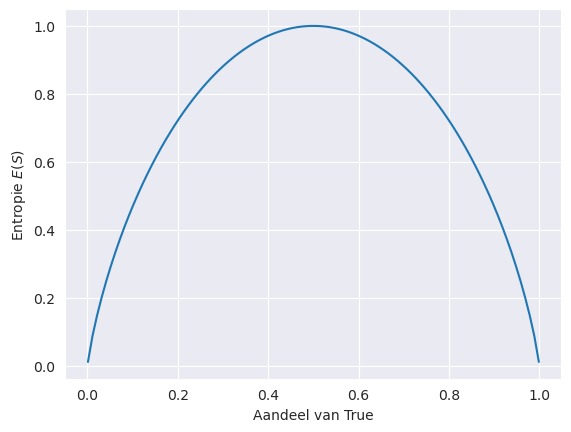

In [14]:
fig, ax = plt.subplots(1, dpi=100)

x = np.linspace(.001,.999,100)
y = -x * np.log2(x) + -(1-x) * np.log2(1-x)
ax.set_xlabel(r"Aandeel van True")
ax.set_ylabel(r"Entropie $E(S)$")

plt.plot(x,y)
plt.show()

## Decision Tree met sklearn

Maak de decision tree met `DecisionTreeClassifier`. Kies als parameter `criterion='entropy'`.

In [15]:
df3 = pd.get_dummies(df, 'vooropleiding')
display(df3)
model = DecisionTreeClassifier(criterion='entropy', max_depth=2)
model.fit(df3.drop('Gehaald', axis = 1), df3['Gehaald'])

,uur,Gehaald,vooropleiding_MBO,vooropleiding_anders,vooropleiding_havo
0,23,True,True,False,False
1,18,True,True,False,False
2,32,True,False,True,False
3,28,False,False,False,True
4,11,False,False,True,False
5,15,False,True,False,False
6,2,False,False,False,True


DecisionTreeClassifier(criterion='entropy', max_depth=2)

Visualisatie van de decision tree met GraphViz.

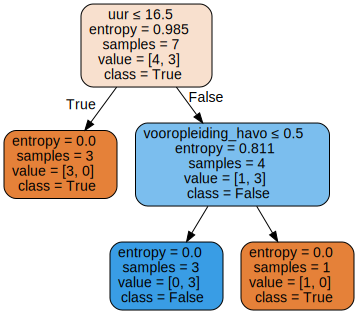

In [16]:
data = export_graphviz(model, out_file=None, feature_names=['uur', 'vooropleiding_MBO', 'vooropleiding_anders', \
                                                           'vooropleiding_havo'], class_names=['True', 'False'],   
                         filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(data)
graph